# Calculate marginal ice zone widths and areas from ACCESS-OM3

This notebook demonstrates how to calculate the marginal ice zone (MIZ) width and area from ACCESS-OM3 MOM–CICE–WW3 outputs.

MIZ defintions:
- Significant wave heights ($H_s$)
- Ice concentration ($a_\text{ice}$)
- Floe size ($r_a$)


**TO-DO**:
- Make download path the user's default project
- Need to check if the directory exists already
- Set colors in pre-amble
- Clean up libraries

In [1]:
### USER EDIT start
# esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cmocean.cm as cmo

import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.feature as cft
import cftime

import geopandas as gpd

from matplotlib.colors import ListedColormap, BoundaryNorm

import os
import requests
import zipfile


from tqdm.notebook import tqdm 
import calendar
import pandas as pd
from datetime import datetime


In [68]:
client = Client(threads_per_worker=1)
client
# print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37791 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37791/status,
Dashboard: /proxy/37791/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40989,Workers: 0
Dashboard: /proxy/37791/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37905,Total threads: 1
Dashboard: /proxy/40171/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35339,


2025-12-09 11:22:19,498 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35463'.
2025-12-09 11:22:19,501 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40957'.
2025-12-09 11:22:23,425 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,429 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,432 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,438 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,440 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,454 - distributed.nanny - WARNING - Restarting worker
2025-12-09 11:22:23,458 - distributed.nanny - WARNING - Restarting worker


### Open the intake-esm datastore

In [3]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [4]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [5]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Load ice concentration, signficant wave height, and floe size

In [117]:
ds = datastore.search(variable=["aice_m", "wave_sig_ht_m", "fsdrad_m"], frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1},
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid

coords = datastore.search(variable=["TLAT", "TLON"], #file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
# coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})

ds = xr.merge([ds, ds_grid])
# ds = ds.rename({'yh': 'nj',
#                 'xh': 'ni'}
# )

ds = ds.assign_coords(coords)
ds = ds.roll(ni=80, roll_coords=True)
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 105MB
Dimensions:        (time: 37, nj: 300, ni: 360)
Coordinates:
  * time           (time) object 296B 1900-01-16 12:00:00 ... 1903-01-16 12:0...
    TLON           (nj, ni) float64 864kB nan nan nan nan ... 72.32 73.23 73.94
    TLAT           (nj, ni) float64 864kB nan nan nan nan ... 88.32 88.1 87.88
    ULON           (nj, ni) float64 864kB nan nan nan nan ... 80.0 80.0 80.0
    ULAT           (nj, ni) float64 864kB nan nan nan nan ... 88.22 88.0 87.78
    NLON           (nj, ni) float64 864kB nan nan nan ... -280.0 -280.0 -280.0
    NLAT           (nj, ni) float64 864kB nan nan nan nan ... 65.21 65.21 65.21
    ELON           (nj, ni) float64 864kB nan nan nan nan ... 72.8 73.6 74.25
    ELAT           (nj, ni) float64 864kB nan nan nan nan ... 88.21 87.99 87.77
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad_m       (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht_m  (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice_m         (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea          (nj, ni) float64 864kB nan nan nan ... 1.234e+09 1.234e+09
    HTE            (nj, ni) float64 864kB nan nan nan ... 4.98e+04 4.972e+04
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [118]:
# ds.roll(ni=80, roll_coords=True)['TLON'].values[100,:]

## Compare a particular day against NSIDC marginal ice zone [product](https://nsidc.org/sites/default/files/g10017-v001-userguide_1_0.pdf)

- https://noaadata.apps.nsidc.org/NOAA/G10017/
- https://nsidc.org/data/g10017/versions/1#anchor-data-access-tools

First, let's get a model time to compare against.

In [119]:
t0 = ds.time[32].values.item()  
t_str = t0.strftime("%Y-%m-%d")
day = t0.strftime("%d")
month = t0.strftime("%m")
if t0.strftime("%Y")[0:3] == '190':
    # RYF RUN
    year = '1990'
else:
    year = t0.strftime("%Y")
if int(year) < 2010: year = '2010' # Obs start in 2010
day_of_year = (t0 - cftime.DatetimeNoLeap(t0.year, 1, 1)).days + 1

In [120]:
def get_ice_charts_data(base_path, folder_name, year):
    '''
    Download MIZ extents (using the sea ice concentration defintion) from NSIDC.
    '''
    print_warn = False
    
    url = f"https://noaadata.apps.nsidc.org/NOAA/G10017/south/{year}/{folder_name}.zip"
    # Year must be a string
    year = str(year)
    
    # File paths
    zip_file = os.path.join(base_path, year, folder_name + ".zip")
    extract_dir = os.path.join(base_path, year, folder_name)

    # If extracted directory already exists, do nothing
    if os.path.isdir(extract_dir):
        if print_warn: print(f"{extract_dir} already exists — skipping download & extraction.")
        return

    year_dir = os.path.join(base_path, year)

    # Create year directory if missing
    if not os.path.isdir(year_dir):
        print(f"Creating directory for year {year}: {year_dir}")
        os.makedirs(year_dir, exist_ok=True)

    # Download the file if missing
    try:
        head = requests.head(url)
        if head.status_code != 200:
            print(f"URL does not exist ({url}) — skipping download.")
            return
    except requests.RequestException as e:
        print(f"Error checking URL: {e} — skipping download.")
        return
        
    if not os.path.exists(zip_file):
        if print_warn: print(f"{zip_file} not found. Downloading…")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(zip_file, "wb") as f:   # download directly to ZIP file
            for chunk in r.iter_content(8192):
                f.write(chunk)
    else:
        print("ZIP file already exists — skipping download.")
        

    if os.path.exists(zip_file):
        if not zipfile.is_zipfile(zip_file):
            print("WARNING: File is not a ZIP archive.")
            raise ValueError("USNIC file is not a valid ZIP.")
    
    if not os.path.exists(extract_dir):
        print(f"Extracting into {extract_dir}…")
        os.makedirs(extract_dir)
        with zipfile.ZipFile(zip_file, "r") as z:
            z.extractall(extract_dir)
         # Delete the zip file
        try:
            os.remove(zip_file)
            if print_warn: print(f"Deleted ZIP file: {zip_file}")
        except Exception as e:
            print(f"WARNING: Could not delete ZIP file: {e}")
    else:
        if print_warn: print(f"{extract_dir} already exists — skipping extraction.")
    return 

folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
base_path = "/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/"
get_ice_charts_data(base_path, folder_name, year)

In [121]:
# f"{day_of_year:03d}"

In [122]:
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
    elif hemisphere.lower().startswith('n'):
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")
    return projection, extent

# def make_fig(number_panels=1, hemisphere='south'):
   
#     projection, extent = get_proj(hemisphere)
    
#     fig, axes = plt.subplots(
#         ncols=number_panels,
#         subplot_kw={'projection': projection},
#         figsize=(4 * number_panels, 4),
#         gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
#     )

    
#     for ax in axes:
#         ax.set_extent(extent, crs=ccrs.PlateCarree())
#        # Add land texture:
#         # ax.imshow(
#         #     blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
#         # )
#         # Make a circle plot
#         theta = np.linspace(0, 2*np.pi, 100)
#         center, radius = [0.5, 0.5], 0.5
#         verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#         circle = mpath.Path(verts * radius + center)
#         ax.set_boundary(circle, transform=ax.transAxes)
#         ax.set_title("NO DATA")

#     return fig, axes

# def plot(dat,  dat_ice=None, ax=None, title=None, hemisphere='south', label="", vmin=None, vmax=None, **kwargs):
#     if title is None:
#     #     # title = dat.attrs['long_name']
#         title = "NO DATA"
        
#     if ax == None:
#         fig, ax = make_fig(hemisphere='south')
    
#     dat.plot.contourf(
#         ax=ax,
#         x="lon", 
#         y="lat", 
#         vmin=vmin,
#         vmax=vmax,
#         transform=ccrs.PlateCarree(),
#         cbar_kwargs={"label": label, # "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45))
#                      "fraction": 0.03, "aspect": 15, "shrink": 0.7},
#         **kwargs
#     )
#     ax.set_title(title);
#     if dat_ice is not None:
#         add_ice_contours(ax, dat_ice, hemisphere)

# def add_ice_contours(ax, dat_ice, hemisphere):

#     projection, extent = get_proj(hemisphere)
        
#     transformed_coor=projection.transform_points(ccrs.PlateCarree(),dat_ice['lon'].values,dat_ice['lat'].values)
#     x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
#     use_transformed_coordinates_directly = True
    
#     if use_transformed_coordinates_directly:
#         cs = ax.contour(x_ster,y_ster,dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
#     else:
#         cs = ax.contour(dat_ice['lon'],dat_ice['lat'],dat_ice['aice_m'],levels=[1e-12, 0.15, 0.8],transform=ccrs.PlateCarree(),
#                     linestyles=[":", "-", "--"],colors="magenta",linewidths=0.5)
                
#     return cs

Calculate the USNIC defintion of the marginal ice zone being between 0.1 and 0.8 

Text(0.5, 1.0, '1902-09-16')

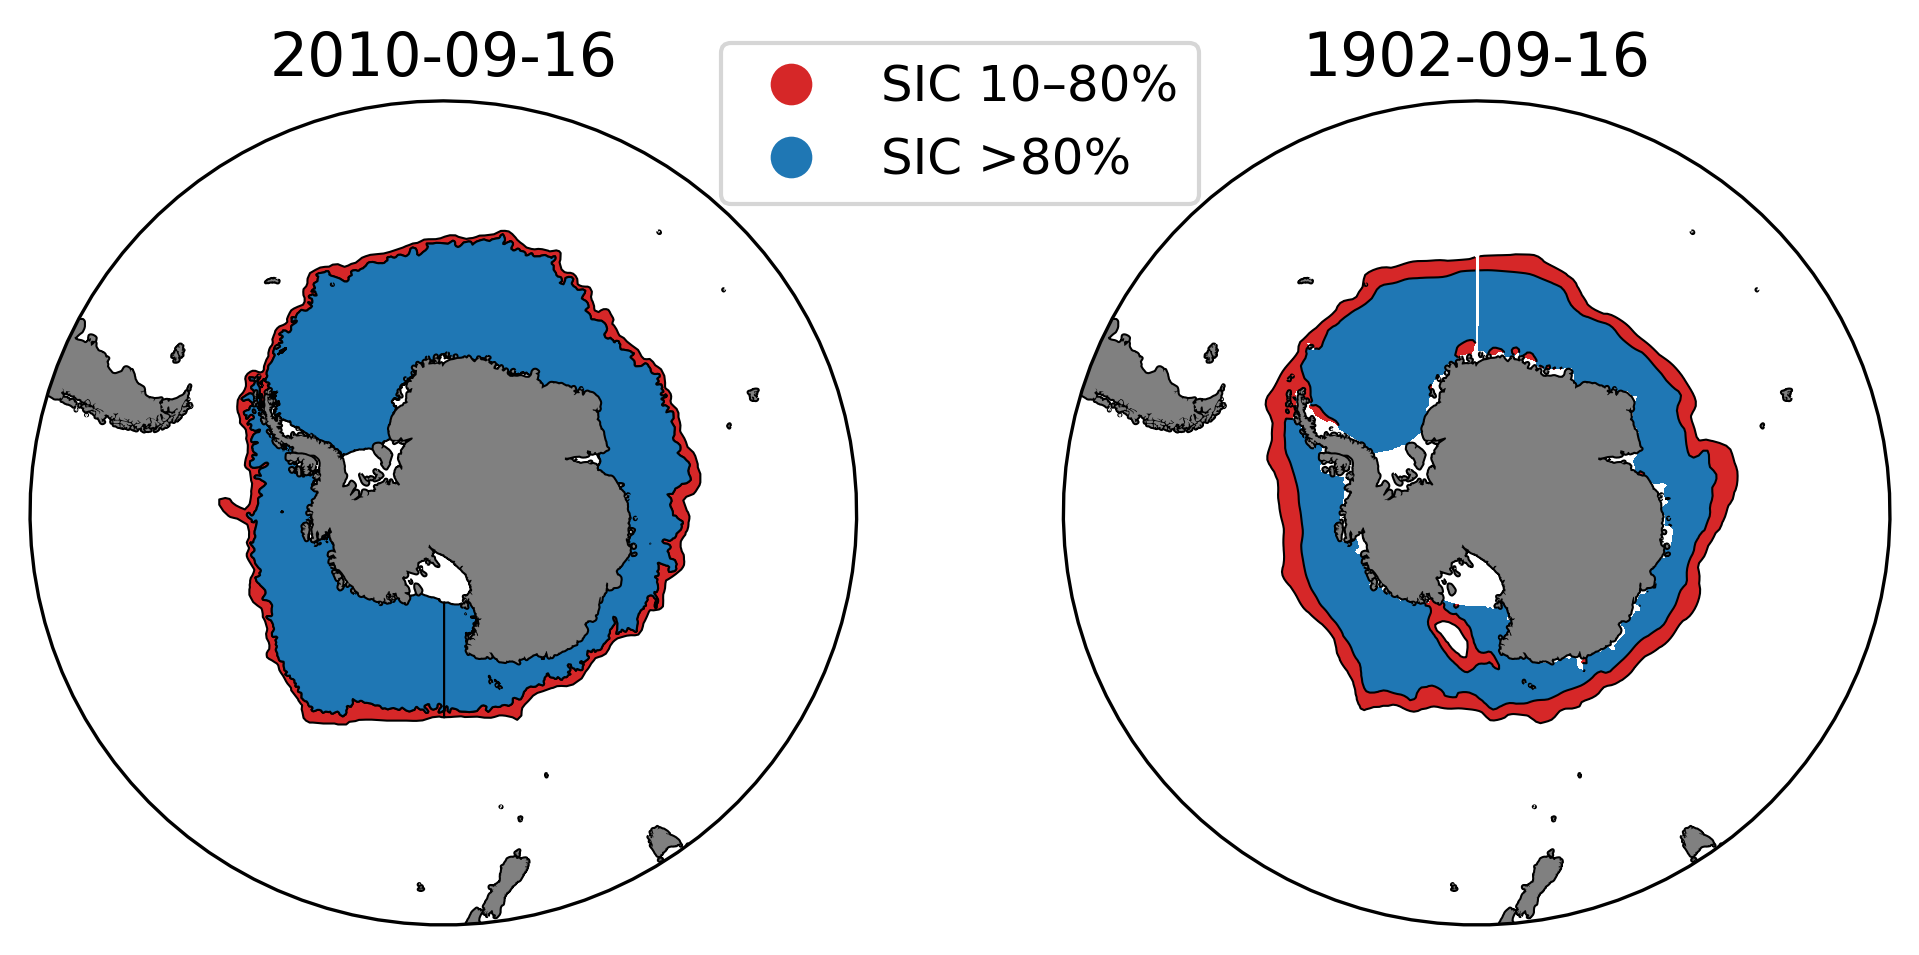

In [123]:
# Plot aesthetics
miz_color = "tab:red"
ice_color = "tab:blue"
bounds = [0.0, 0.1, 0.8, 1.0]
cmap = ListedColormap(["white", miz_color, ice_color])  
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Make figure
number_panels = 2
hemisphere = "south"
projection, extent = get_proj(hemisphere)
    
fig, axes = plt.subplots(
    ncols=number_panels,
    subplot_kw={'projection': projection},
    figsize=(4 * number_panels, 4),
    gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
)

for ax in axes:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='none',
                                    facecolor='gray', linewidth=0.5)
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    # Make a circle plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_title("NO DATA")


# fig, axes = make_fig(number_panels=2, hemisphere='south')



# Load shapefile
cmap_obs = ListedColormap([miz_color, ice_color])  
bounds_obs = [0, 1, 2]
norm_obs = BoundaryNorm(bounds_obs, cmap_obs.N)

shp_file = glob.glob(os.path.join(base_path, year, folder_name, "*.shp"))[0]
gdf = gpd.read_file(shp_file)

# Reproject
gdf_proj = gdf.to_crs(epsg=3031)

gdf_proj.plot(
    ax=axes[0],
    column="ICECODE",
    cmap=cmap_obs,
    norm=norm_obs,
    edgecolor="black",
    linewidth=0.5,
    legend=True, 
    figsize=(8, 8),
)

leg = axes[0].get_legend()
for text, new_label in zip(leg.get_texts(), ['SIC 10–80%', 'SIC >80%']):
    text.set_text(new_label)
leg.set_loc('upper center')
leg.set_bbox_to_anchor((1.125, 1.1))
axes[0].set_title(f"{year}-{month}-{day}")

ds.sel(time=t0)['aice_m'].plot.contourf(
    ax=axes[1],
    x="TLON",
    y="TLAT",
    levels=bounds,  
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = ds.sel(time=t0)['aice_m'].plot.contour(
    ax=axes[1],
    x="TLON",
    y="TLAT",
    levels=bounds[1:],  
    colors='k',    
    linewidths=0.5,
    transform=ccrs.PlateCarree()
)

axes[1].set_title(t_str)

### Climatology

In [124]:
# Take the 15th of each month
days_of_year = np.array([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])
years = np.arange(2010, 2026)

base_path = "/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/"

rows = []   # List of dictionaries for final dataframe

for year in tqdm(years):
    for i, day_of_year in enumerate(days_of_year):
        folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
        get_ice_charts_data(base_path, folder_name, year)
        shp_file = glob.glob(os.path.join(base_path, str(year), folder_name, "*.shp"))

        # Default values
        miz_extent = np.nan
        inner_extent = np.nan

        if not shp_file:
            print(f"No shapefile for {folder_name} — skipping.")
        else:
            gdf = gpd.read_file(shp_file[0])

            # Find correct area column
            possible_cols = ["SHAPE_Area", "Shape_Area"]
            area_col = next((c for c in possible_cols if c in gdf.columns), None)

            if area_col is None:
                print(f"No area column for {folder_name}. Columns: {list(gdf.columns)}")
                print(gdf)
            else:
                areas = gdf.groupby("ICECODE")[area_col].sum()
                miz_extent = areas.iloc[0]
                inner_extent = areas.iloc[1]

        month = i + 1
        rows.append({
            "year": year,
            "month": month,
            "date": datetime(year, month, 15),
            "miz_extent": miz_extent,
            "inner_extent": inner_extent,
            "sea_ice_extent": miz_extent + inner_extent
        })

df = pd.DataFrame(rows)
df

  0%|          | 0/16 [00:00<?, ?it/s]

URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010015sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010015sc_pl_a — skipping.
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010046sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010046sc_pl_a — skipping.
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010074sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010074sc_pl_a — skipping.


,year,month,date,miz_extent,inner_extent,sea_ice_extent
0,2010,1,2010-01-15,NaN,NaN,NaN
1,2010,2,2010-02-15,NaN,NaN,NaN
2,2010,3,2010-03-15,NaN,NaN,NaN
3,2010,4,2010-04-15,5.453622e+11,5.968000e+12,6.513362e+12
4,2010,5,2010-05-15,5.601921e+11,9.874222e+12,1.043441e+13
...,...,...,...,...,...,...
187,2025,8,2025-08-15,1.801164e+12,1.504895e+13,1.685011e+13
188,2025,9,2025-09-15,2.009964e+12,1.674954e+13,1.875950e+13
189,2025,10,2025-10-15,2.011426e+12,1.567896e+13,1.769038e+13
190,2025,11,2025-11-15,3.066872e+12,1.322212e+13,1.628899e+13


### Calculate climatology of observations

In [125]:
df_clim = df.groupby('month').mean()
df_clim

,year,date,miz_extent,inner_extent,sea_ice_extent
month,,,,,
1,2017.5,2017-07-16 06:00:00,2.843787e+12,4.069199e+12,6.912986e+12
2,2017.5,2017-08-16 06:00:00,1.882043e+12,2.233526e+12,4.115569e+12
3,2017.5,2017-09-13 12:00:00,1.100344e+12,3.370462e+12,4.470807e+12
4,2017.5,2017-10-14 12:00:00,8.275513e+11,5.975079e+12,6.802630e+12
5,2017.5,2017-11-13 12:00:00,9.139147e+11,9.095975e+12,1.000989e+13
6,2017.5,2017-12-14 12:00:00,1.521787e+12,1.204202e+13,1.356381e+13
7,2017.5,2018-01-13 12:00:00,1.672999e+12,1.449856e+13,1.617156e+13
8,2017.5,2018-02-13 12:00:00,1.946506e+12,1.638380e+13,1.833031e+13
9,2017.5,2018-03-16 12:00:00,2.010428e+12,1.736447e+13,1.937490e+13


### Calculate the model's climatology

In [126]:
ds_clim = ds.groupby('time.month').mean('time').compute()
ds_clim

<xarray.Dataset> Size: 59MB
Dimensions:        (month: 12, nj: 300, ni: 360)
Coordinates:
    TLON           (nj, ni) float64 864kB nan nan nan nan ... 72.32 73.23 73.94
    TLAT           (nj, ni) float64 864kB nan nan nan nan ... 88.32 88.1 87.88
    ULON           (nj, ni) float64 864kB nan nan nan nan ... 80.0 80.0 80.0
    ULAT           (nj, ni) float64 864kB nan nan nan nan ... 88.22 88.0 87.78
    NLON           (nj, ni) float64 864kB nan nan nan ... -280.0 -280.0 -280.0
    NLAT           (nj, ni) float64 864kB nan nan nan nan ... 65.21 65.21 65.21
    ELON           (nj, ni) float64 864kB nan nan nan nan ... 72.8 73.6 74.25
    ELAT           (nj, ni) float64 864kB nan nan nan nan ... 88.21 87.99 87.77
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nj, ni
Data variables:
    fsdrad_m       (month, nj, ni) float64 10MB nan nan nan ... 752.7 763.9
    wave_sig_ht_m  (month, nj, ni) float64 10MB nan nan ... 0.006138 0.006256
    aice_m         (month, nj, ni) float64 10MB nan nan nan ... 0.9965 0.997
    tarea          (month, nj, ni) float64 10MB nan nan ... 1.234e+09 1.234e+09
    HTE            (month, nj, ni) float64 10MB nan nan ... 4.98e+04 4.972e+04
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

## Compare MIZ extents against observations

In [127]:
def _get_mask(ds, definition, hemisphere, threshold=None):
    # Set defaults for each definition
    defaults = {'wave_sig_ht': 0.05, 'aice': 0.8, 'fsdrad': 200}
    if threshold is None:
        try:
            threshold = defaults[definition]
        except KeyError:
            raise ValueError(f"Unknown definition: {definition}")

    # Example for aice
    aice_var = _get_var(ds, ['aice_m', 'aice'])
    wave_var = _get_var(ds, ['wave_sig_ht_m', 'wave_sig_ht'])
    fsd_var = _get_var(ds, ['fsdrad_m', 'fsdrad'])
    
    # Hemisphere mask
    if hemisphere == 'south':
        hemi_mask = ds['TLAT'] < 0
    elif hemisphere == 'north':
        hemi_mask = ds['TLAT'] > 0
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")

    # Base ice presence mask
    base_mask = ds[aice_var] > 0.15

    # Definition-specific condition
    if definition == 'wave_sig_ht':
        cond = ds[wave_var] > threshold
    elif definition == 'aice':
        cond = ds[aice_var] < threshold
    elif definition == 'fsdrad':
        cond = ds[fsd_var] < threshold
    elif definition in ['SIE', 'SIA']:
        cond = base_mask
    else:
        raise ValueError(f"Unknown definition: {definition}")

    return base_mask & cond & hemi_mask

def _get_var(ds, names):
    """Return the first matching variable name in ds."""
    for n in names:
        if n in ds:
            return n
    raise KeyError(f"None of the variables {names} found in dataset.")

def _integrate_area(ds, mask, definition):
    if definition == "SIA":
        return ds['tarea']*ds['aice_m'].where(mask).sum(dim=['ni', 'nj'])
    else:
        return ds['tarea'].where(mask).sum(dim=['ni', 'nj'])

def calculate_area(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    sea_ice_extent = _integrate_area(ds_cice, mask_2d, definition) * 1e-12

    if definition in ["wave_sig_ht", "aice", "fsdrad"]:
        name = "MIZ area"
    elif definition == "SIE":
        name = "Sea ice extent"
    elif definition == "SIA":
        name = "Sea ice area"

    return xr.DataArray(
        sea_ice_extent,
        dims=sea_ice_extent.dims,
        coords={'month': ds_cice['month']},
        name=name,
        attrs={
            'units': '10^6 km^2',
            'description': f'MIZ extent ({definition})'
        }
    )


In [128]:
# Calculate Antarctic extents
hemisphere = "south"
antarctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
antarctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
antarctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [129]:
# Calculate Arctic extents
hemisphere = "north"
arctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
arctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
arctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

## Compare MCW with NSIDC using the sea ice concentration definition

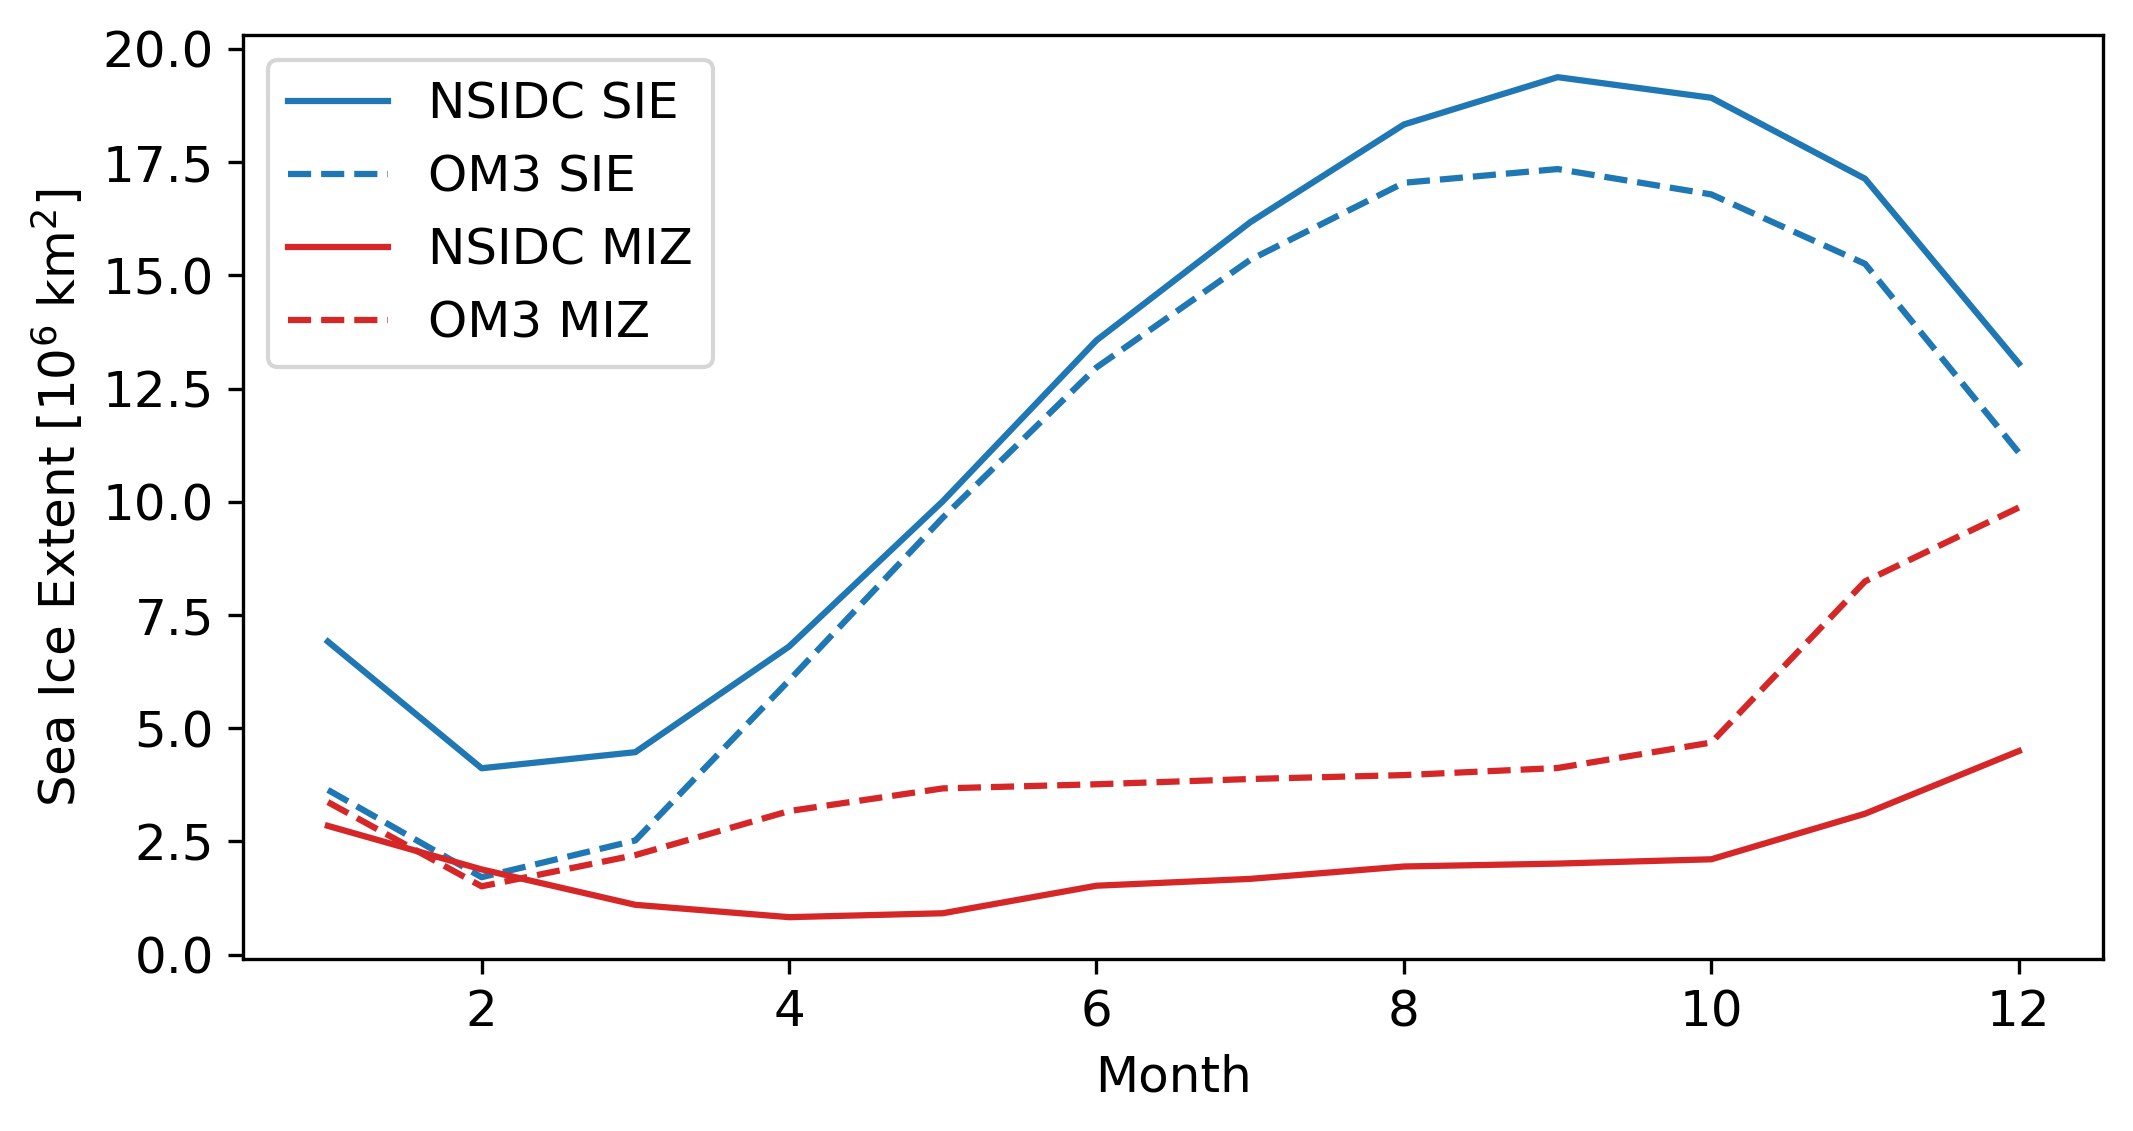

In [130]:
color_miz = 'tab:red'
color_sie = 'tab:blue'

fig, ax = plt.subplots(
    nrows=1,
    figsize=(4 * number_panels, 4),
    sharex=True,
)

# SIE
ax.plot(df_clim.index, df_clim['sea_ice_extent'] * 1e-12,
        color=color_sie,
        linestyle='-',
        label="NSIDC SIE",
)

ax.plot(antarctic_miz_extent_aice.month, antarctic_sie,
        color=color_sie,
        linestyle='--',
        label="OM3 SIE",
)


# MIZ 
ax.plot(df_clim.index, df_clim['miz_extent'] * 1e-12,
        color=color_miz,
        linestyle='-',
        label="NSIDC MIZ",
)

ax.plot(antarctic_miz_extent_aice.month, antarctic_miz_extent_aice,
        color=color_miz,
        linestyle='--',
        label="OM3 MIZ",
)


ax.set_xlabel("Month")
ax.set_ylabel("Sea Ice Extent [10$^6$ km$^2$]")

ax.legend()

### Time series for one year

In [131]:
if calendar.isleap(int(year)):
    days_of_year = np.arange(1, 367, 1)
else:
    days_of_year = np.arange(1, 366, 1)
    
base_path = "/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/"

year = '2011'
ice_charts_miz = []
ice_charts_inner = []
for day_of_year in tqdm(days_of_year):
    print(day_of_year)
    folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
    get_ice_charts_data(base_path, folder_name, year)
    shp_file = glob.glob(os.path.join(base_path, year, folder_name, "*.shp"))
    
    try:
        gdf = gpd.read_file(shp_file[0])
        areas = gdf.groupby("ICECODE")["SHAPE_Area"].sum()
        ice_charts_miz.append(areas.iloc[0])
        ice_charts_inner.append(areas.iloc[1])
    except Exception as e:
        print(f"Error reading shapefile for day {day_of_year}: {e} — skipping.")
        ice_charts_miz.append(np.nan)    
        ice_charts_inner.append(np.nan)
        continue
    # gdf = gpd.read_file(shp_file)
    # areas = gdf.groupby("ICECODE")["SHAPE_Area"].sum()
    # # print(area_by_code)
    # ice_charts_miz.append(areas[0])
    # ice_charts_inner.append(areas[1])
ice_charts_miz = np.array(ice_charts_miz)
ice_charts_inner = np.array(ice_charts_inner)

  0%|          | 0/365 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2011/nic_miz2011121sc_pl_a.zip) — skipping download.
Error reading shapefile for day 121: list index out of range — skipping.
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


## Compare MIZ widths against observations

### Calculate MIZ widths

In [135]:
def _integrate_width(width, ds, method):
    if method == 'simple':
        return width.sum(dim='nj', skipna=True)
    elif method == 'weighted':
        aice_var = _get_var(ds, ['aice_m', 'aice'])
        return (width * ds[aice_var]).sum(dim='nj', skipna=True)
    else:
        raise ValueError(f"Unknown integration: {method}")

def _reduce_width(width, method, mask):
    if mask:
        width = width.where(width != 0)
    if method == 'median':
        return width.median(dim='ni', skipna=True)
    elif method == 'mean':
        return width.mean(dim='ni', skipna=True)
    else:
        raise ValueError(f"Unknown measure: {method}")

def calculate_miz_width(ds_cice, definition='wave', threshold=0.3, integration='simple', 
                        measure='median', mask=True, hemisphere='south', freq='monthly'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    miz_width_2d = ds_cice['HTE'].where(mask_2d) / 1000 # m to km
    miz_width_1d = _integrate_width(miz_width_2d, ds_cice, integration)
    miz_width_reduced = _reduce_width(miz_width_1d, measure, mask)

    if freq == 'monthly':
        coords = {'month': ds_cice['month']}
    elif freq == 'dayofyear':
        coords = {'dayofyear': ds_cice['dayofyear']}

    return xr.DataArray(
        miz_width_reduced,
        dims=miz_width_reduced.dims,
        coords=coords,
        name='miz_width',
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )

In [136]:
hemisphere='south'
antarctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [137]:
hemisphere='north'
arctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

### Load in observations (*Fraser et al., 2025*)

In [138]:
def ReadInAltika(version, year=2019):
    if version == '0.6':
        month_range = range(1,13)
        df = pd.concat((pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_6/' + str(year) + ("%02d" % (month,)) + '_output_v0_6.csv') 
                        for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                        ignore_index=True)
        
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    
    elif version == '0.10':
        # Version 0.10
        df_raw = pd.read_csv('data/v0_10/' + str(year) + '_all_output_v0_10.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.11':
        # Version 0.11
        df_raw = pd.read_csv('data/v0_11/' + str(year) + '_all_output_v0_11.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.12':
        # Version 0.12
        df_raw = pd.read_csv('data/v0_12/' + str(year) + '_all_output_v0_12.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    elif version == '0.15':
        # Version 0.15
        df_raw = pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_15/' + str(year) + '_all_output_v0_15.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        
    # Add dates to dataframe
    df['date'] = pd.to_datetime(df["first_meas_time"])#, format='%Y-%m-%d').dt.round("d")
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    return df

In [139]:
from tqdm.notebook import tqdm

years = range(2013, 2024)
dfs = []

# swh_min = 10**-12
# swh_max = 100
# miz_max = 10000
# miz_min = -10**-12

for year in tqdm(years):
    # print(year)
    df = pd.DataFrame(ReadInAltika(version='0.15', year=year))
    df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    df['date'] = pd.to_datetime(df["first_meas_time"]).dt.date # , format='%Y-%m-%d %H:%M:%S.%f').dt.date
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['mizwidth_lat'] = abs(df['latAtAltiKaEdge'] - df['latAtInnerMIZ'])*111.32 # Alex's conversion from latitudes to km

    dfs.append(df)
# Combine into one dataframe
df_all = pd.concat(dfs, ignore_index=True)
# df_tmp = df_all.copy()
# condition_met_df = (df_tmp['swhAtMyEdge'] < swh_max) & (df_tmp['swhAtMyEdge'] > swh_min) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] < miz_max) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] > miz_min)
# df_all = df_tmp.where(condition_met_df)
df_all.head()

  0%|          | 0/11 [00:00<?, ?it/s]

,first_meas_time,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,date,day,year,month,mizwidth_lat
0,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
1,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
2,2013-03-14 07:20:03.662676,1.903122,1.938063,-68.331988,2.380483,-68.678470,3.743463,-69.687394,167.533329,124.858594,2013-03-14,14,2013,3,112.313420
3,2013-03-14 08:10:21.720821,2.011015,119.110686,-65.043592,118.766595,-65.397606,118.733795,-65.434442,47.005832,4.380543,2013-03-14,14,2013,3,4.100584
4,2013-03-14 09:00:39.517474,1.635128,339.407504,-70.235543,340.841359,-71.139443,341.304206,-71.418344,149.157700,35.263525,2013-03-14,14,2013,3,31.047259


In [140]:
# Average monthly
df_clim = df_all.groupby('month').mean(numeric_only=True)
df_clim.head()

,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,day,year,mizwidth_lat
month,,,,,,,,,,,,
1,2.184007,166.430348,-67.106528,166.185463,-67.260895,166.206238,-67.713897,78.311200,55.655682,14.763496,2018.092891,50.428206
2,2.253309,180.162562,-68.080052,180.173450,-68.236231,180.146264,-68.592000,65.544679,44.085870,14.367722,2017.931523,39.604290
3,2.410002,188.731202,-68.150036,188.702315,-68.448503,188.702460,-68.930079,97.158424,60.083969,17.333527,2017.903988,53.609025
4,2.739153,179.746850,-66.636031,179.546947,-66.894250,179.511327,-67.828733,148.234037,114.969863,16.038139,2017.868374,104.026625
5,2.960517,176.019193,-64.907779,175.969736,-65.193372,175.948523,-66.395179,181.485997,145.995876,16.094722,2017.953533,133.785139


### Plot the different MIZ width defintions

In [141]:
def figure(region=None):
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.12)

    axes[0].text(0.0, 1.03, 'a) ANTARCTIC', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ARCTIC', fontsize=12, fontweight='bold', transform=axes[1].transAxes)
    # axes[2].text(0.0, 1.03, 'c) ACCESS-OM3 - ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[2].transAxes)

    # axes[0].text(0.99, 1.03, "ANTARCTIC", ha='right', fontsize=12, transform=axes[0].transAxes)
    # axes[1].text(0.99, 1.03, "ARCTIC", ha='right', fontsize=12, transform=axes[1].transAxes)
    
    for i, ax in enumerate(axes):
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
    
    # axes[0].set_ylabel('Sea ice volume tendency\n(x1000 km$^3$ day$^{-1}$)')
        
    return fig, axes

Text(0, 0.5, 'MIZ width [km]')

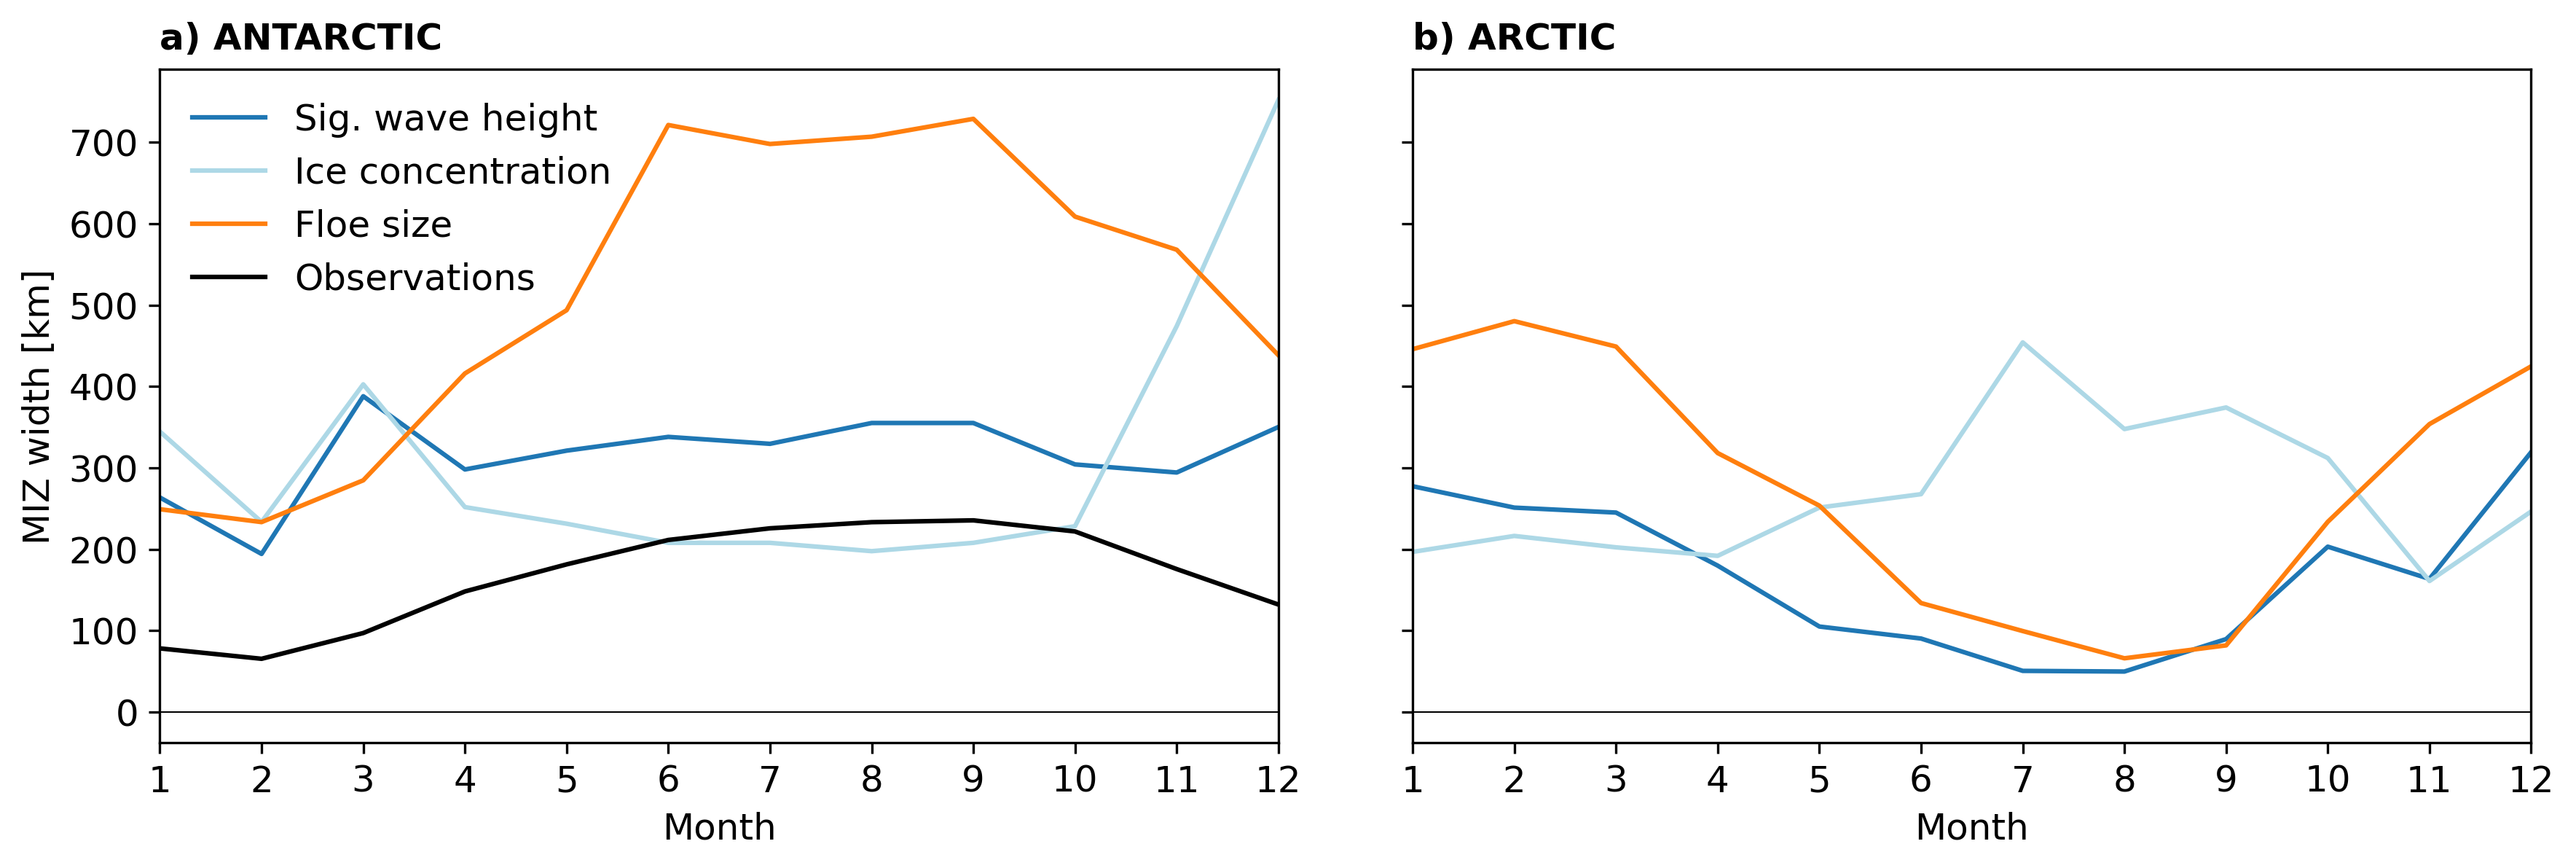

In [142]:
# region = 'ANTARCTICA'
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_width_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_width_fsdrad, label='Floe size')
axes[0].plot(x, df_clim['mizWidthAlongTrackFromMyEdge'], color='k', label="Observations")

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_width_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_width_fsdrad, label='Floe size')

axes[0].set_ylabel("MIZ width [km]")

### MIZ area

Text(0, 0.5, 'Sea Ice Area [$10^6$ km$^2$]')

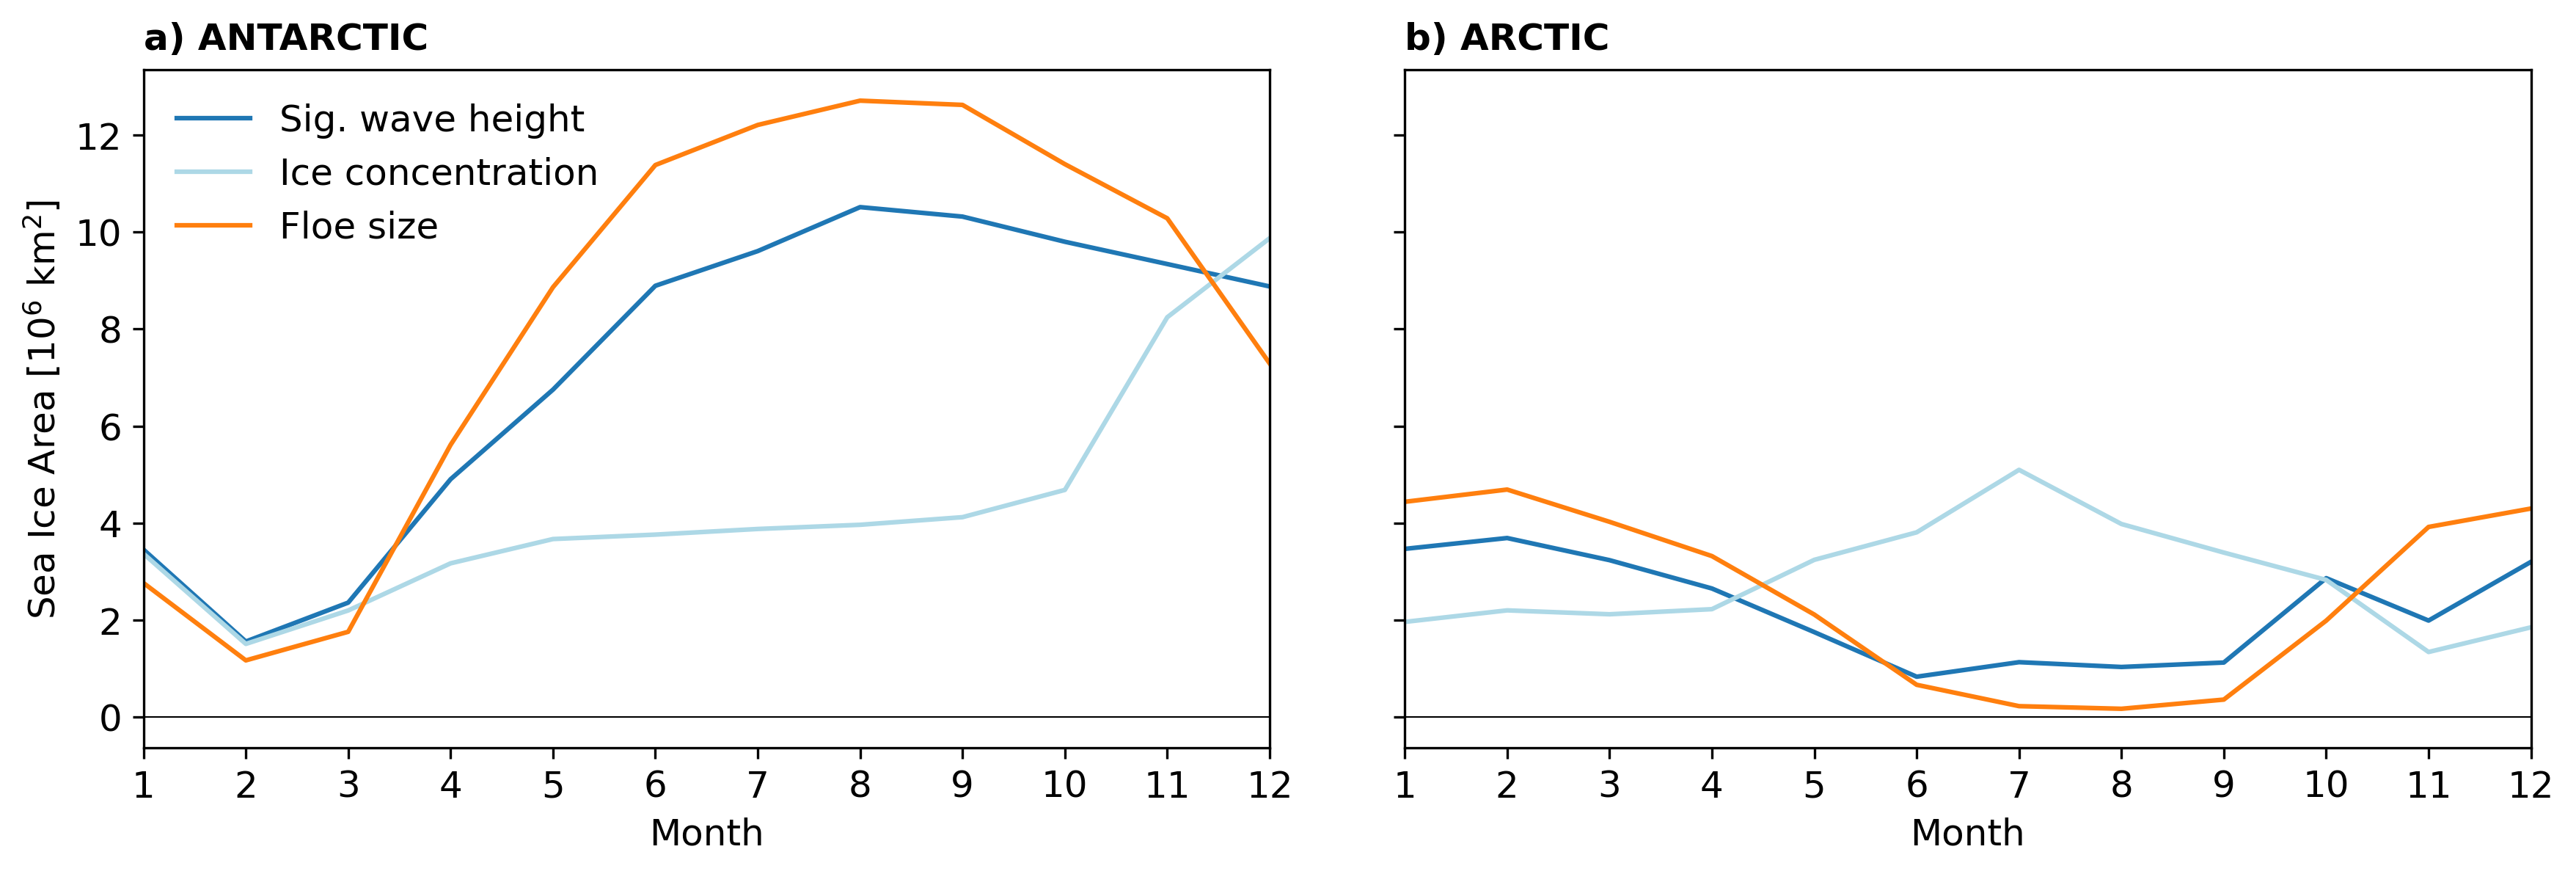

In [143]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_extent_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad, label='Floe size')

axes[0].set_ylabel("Sea Ice Area [$10^6$ km$^2$]")

### MIZ fraction

Text(0, 0.5, 'Marginal Ice Zone Fraction')

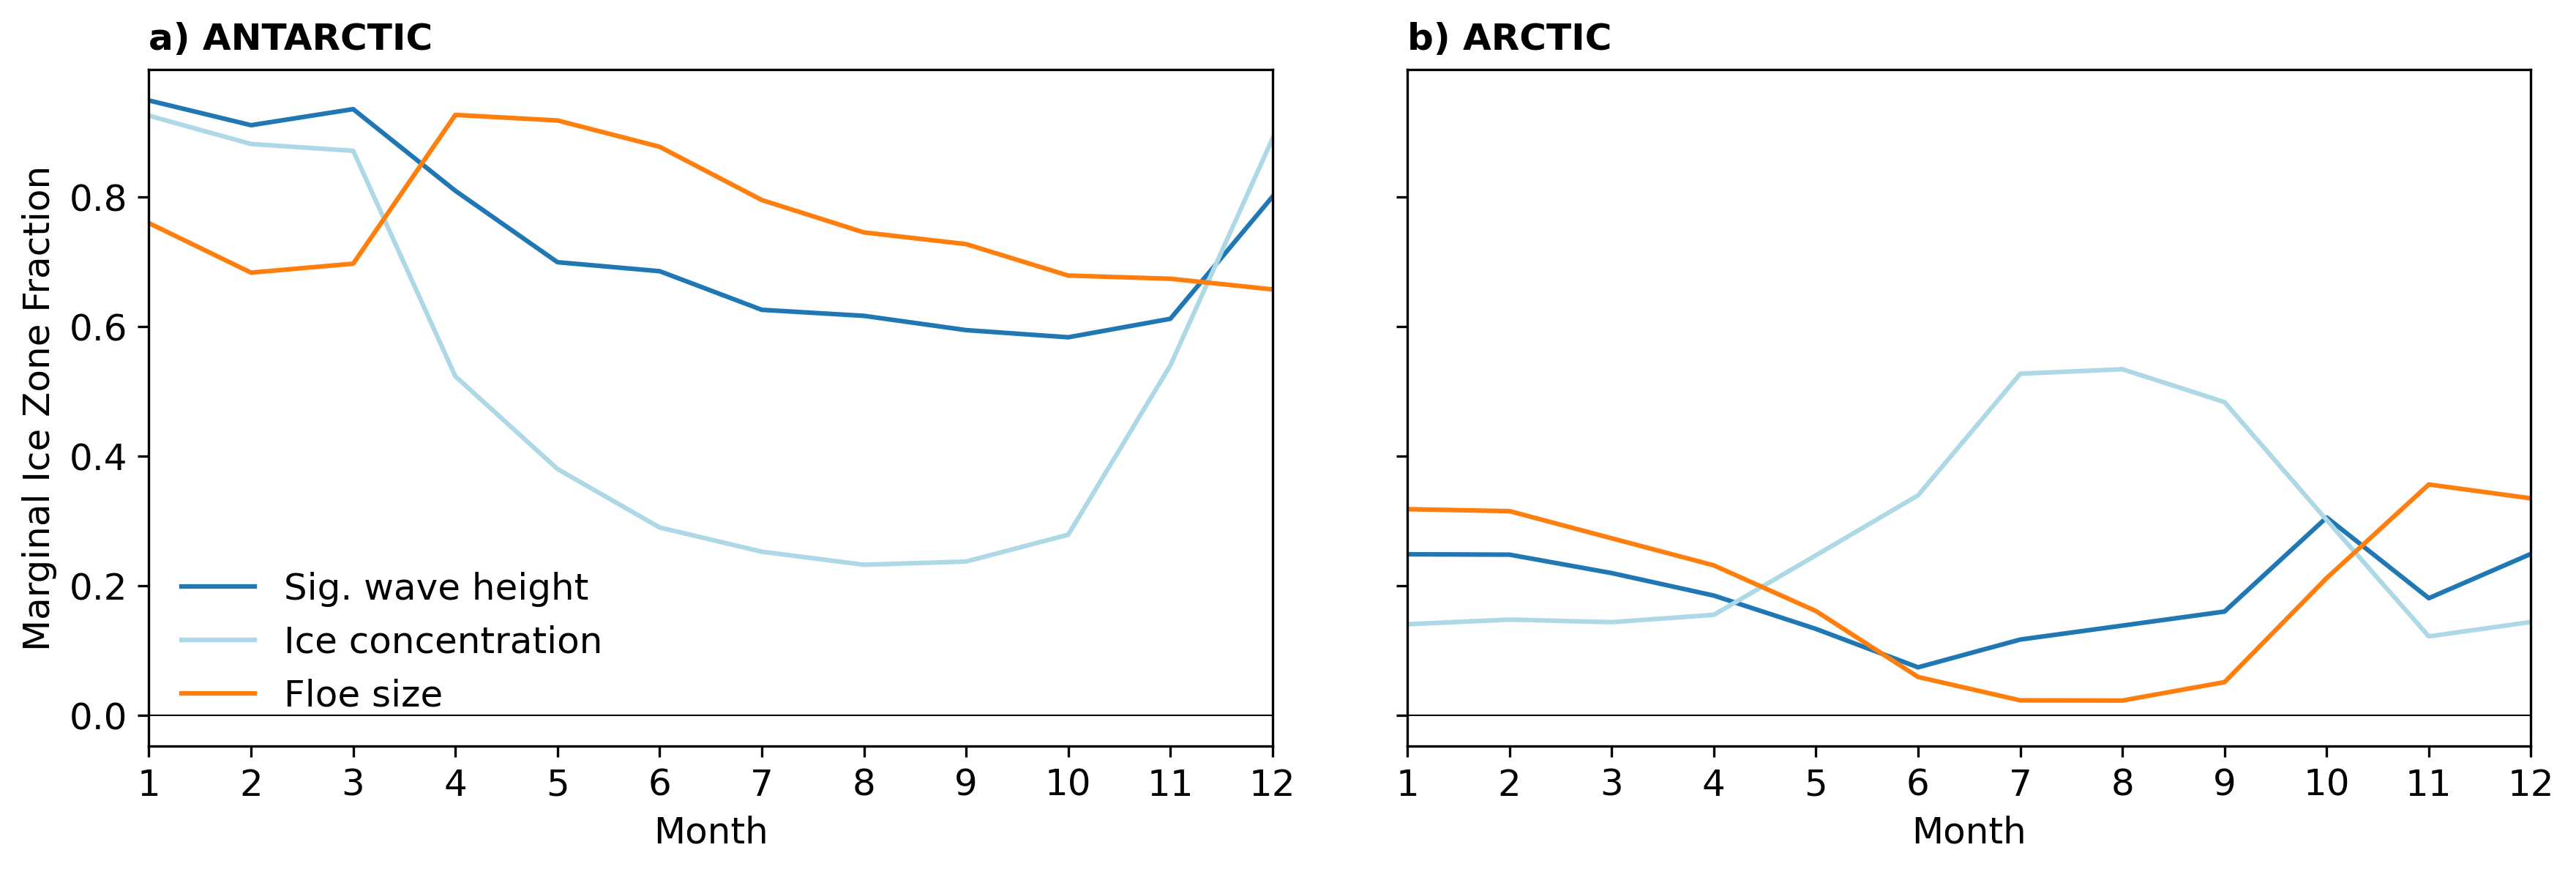

In [144]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave/antarctic_sie, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice/antarctic_sie, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad/antarctic_sie, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc="lower left")

axes[1].plot(x, arctic_miz_extent_wave/arctic_sie, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice/arctic_sie, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad/arctic_sie, label='Floe size')

axes[0].set_ylabel("Marginal Ice Zone Fraction")

## Daily outputs

In [145]:
# Average monthly
df_all['doy'] = pd.to_datetime(df_all['date']).dt.dayofyear
df_doy = df_all.groupby('doy').mean(numeric_only=True)

In [146]:
ds_daily = datastore.search(variable=["aice", "wave_sig_ht", "fsdrad"], frequency="1day").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid

ds_daily = xr.merge([ds_daily, ds_grid])
ds_daily = ds_daily.isel(time=slice(60,-1))
ds_daily

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 3GB
Dimensions:      (time: 1065, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 9kB 1900-03-02 12:00:00 ... 1903-01-30 12:00:00
    TLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    TLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: nj, ni
Data variables:
    aice         (time, nj, ni) float64 920MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 920MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 920MB dask.array<chunksize=(15, 300, 360), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    HTE          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,ti...
    intake_esm_attrs:variable_units:          1,1,1,1,1,radians,radians,m,m,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [178]:
ds_doy = ds_daily.groupby('time.dayofyear').mean('time').compute()
ds_doy

<xarray.Dataset> Size: 2GB
Dimensions:      (dayofyear: 365, nj: 300, ni: 360)
Coordinates:
    TLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    TLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    NLAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELON         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ELAT         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
  * dayofyear    (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Dimensions without coordinates: nj, ni
Data variables:
    aice         (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    wave_sig_ht  (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    fsdrad       (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    tarea        (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
    HTE          (dayofyear, nj, ni) float64 315MB nan nan nan ... nan nan nan
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    time_period_freq:                         day_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,ti...
    intake_esm_attrs:variable_units:          1,1,1,1,1,radians,radians,m,m,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [179]:
hemisphere='south'
floe_size_threshold = 50 # m

antarctic_miz_width_wave_d = calculate_miz_width(ds_doy, definition='wave_sig_ht', hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_wave_d_1cm = calculate_miz_width(ds_doy, definition='wave_sig_ht', threshold=0.01, hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_wave_d_5cm = calculate_miz_width(ds_doy, definition='wave_sig_ht', threshold=0.05, hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_aice_d = calculate_miz_width(ds_doy, definition='aice', threshold=0.8, hemisphere=hemisphere, freq='dayofyear')
antarctic_miz_width_fsdrad_d = calculate_miz_width(ds_doy, definition='fsdrad', threshold=floe_size_threshold, hemisphere=hemisphere, freq='dayofyear')

antarctic_miz_width_wave_d_eff = calculate_miz_width(ds_doy, definition='wave_sig_ht', hemisphere=hemisphere, freq='dayofyear', integration='weighted')
antarctic_miz_width_wave_d_eff_1cm = calculate_miz_width(ds_doy, definition='wave_sig_ht', threshold=0.01, hemisphere=hemisphere, freq='dayofyear', integration='weighted')
antarctic_miz_width_wave_d_eff_5cm = calculate_miz_width(ds_doy, definition='wave_sig_ht', threshold=0.05, hemisphere=hemisphere, freq='dayofyear', integration='weighted')
antarctic_miz_width_fsdrad_d_eff = calculate_miz_width(ds_doy, definition='fsdrad', threshold=floe_size_threshold, hemisphere=hemisphere, freq='dayofyear', integration='weighted')

Text(0, 0.5, 'MIZ width [km]')

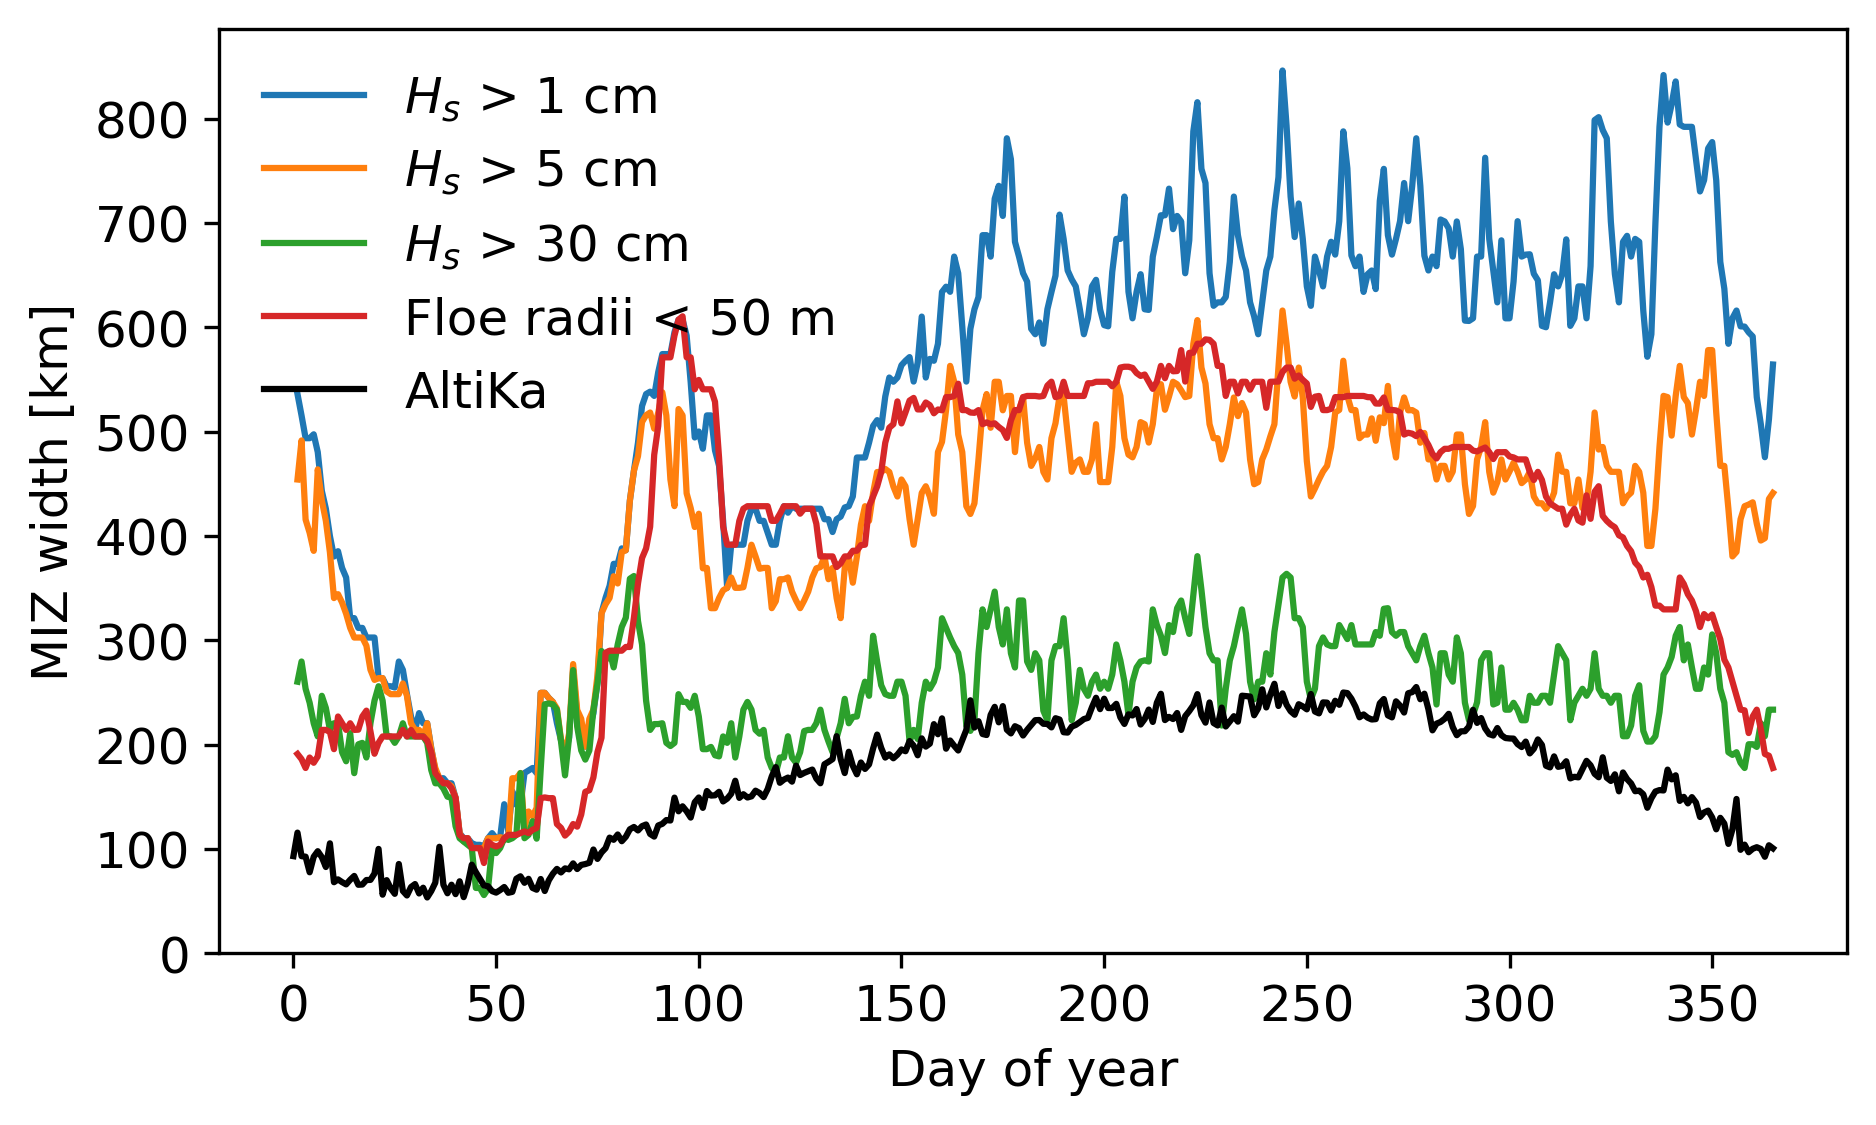

In [180]:
# region = 'ANTARCTICA'
fig, axes = plt.subplots(ncols=1, figsize=(7,4), sharex=True, sharey=True)
ax = axes
x = ds_doy.dayofyear
ax.plot(x, antarctic_miz_width_wave_d_1cm, label='$H_s$ > 1 cm')
ax.plot(x, antarctic_miz_width_wave_d_5cm, label='$H_s$ > 5 cm')
ax.plot(x, antarctic_miz_width_wave_d, label='$H_s$ > 30 cm')

ax.plot(x, antarctic_miz_width_fsdrad_d, label=f'Floe radii < {floe_size_threshold} m')

# axes[0].plot(x, antarctic_miz_width_aice_d, label='Ice concentration', color='lightblue')
# axes[0].plot(x, antarctic_miz_width_fsdrad_d, label='Floe size')
ax.plot(range(366), df_doy['mizWidthAlongTrackFromMyEdge'], color='k', label="AltiKa")

ax.legend(frameon=False, ncols=1, fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlabel("Day of year")
ax.set_ylabel("MIZ width [km]")

Text(0, 0.5, 'Effective MIZ width [km]')

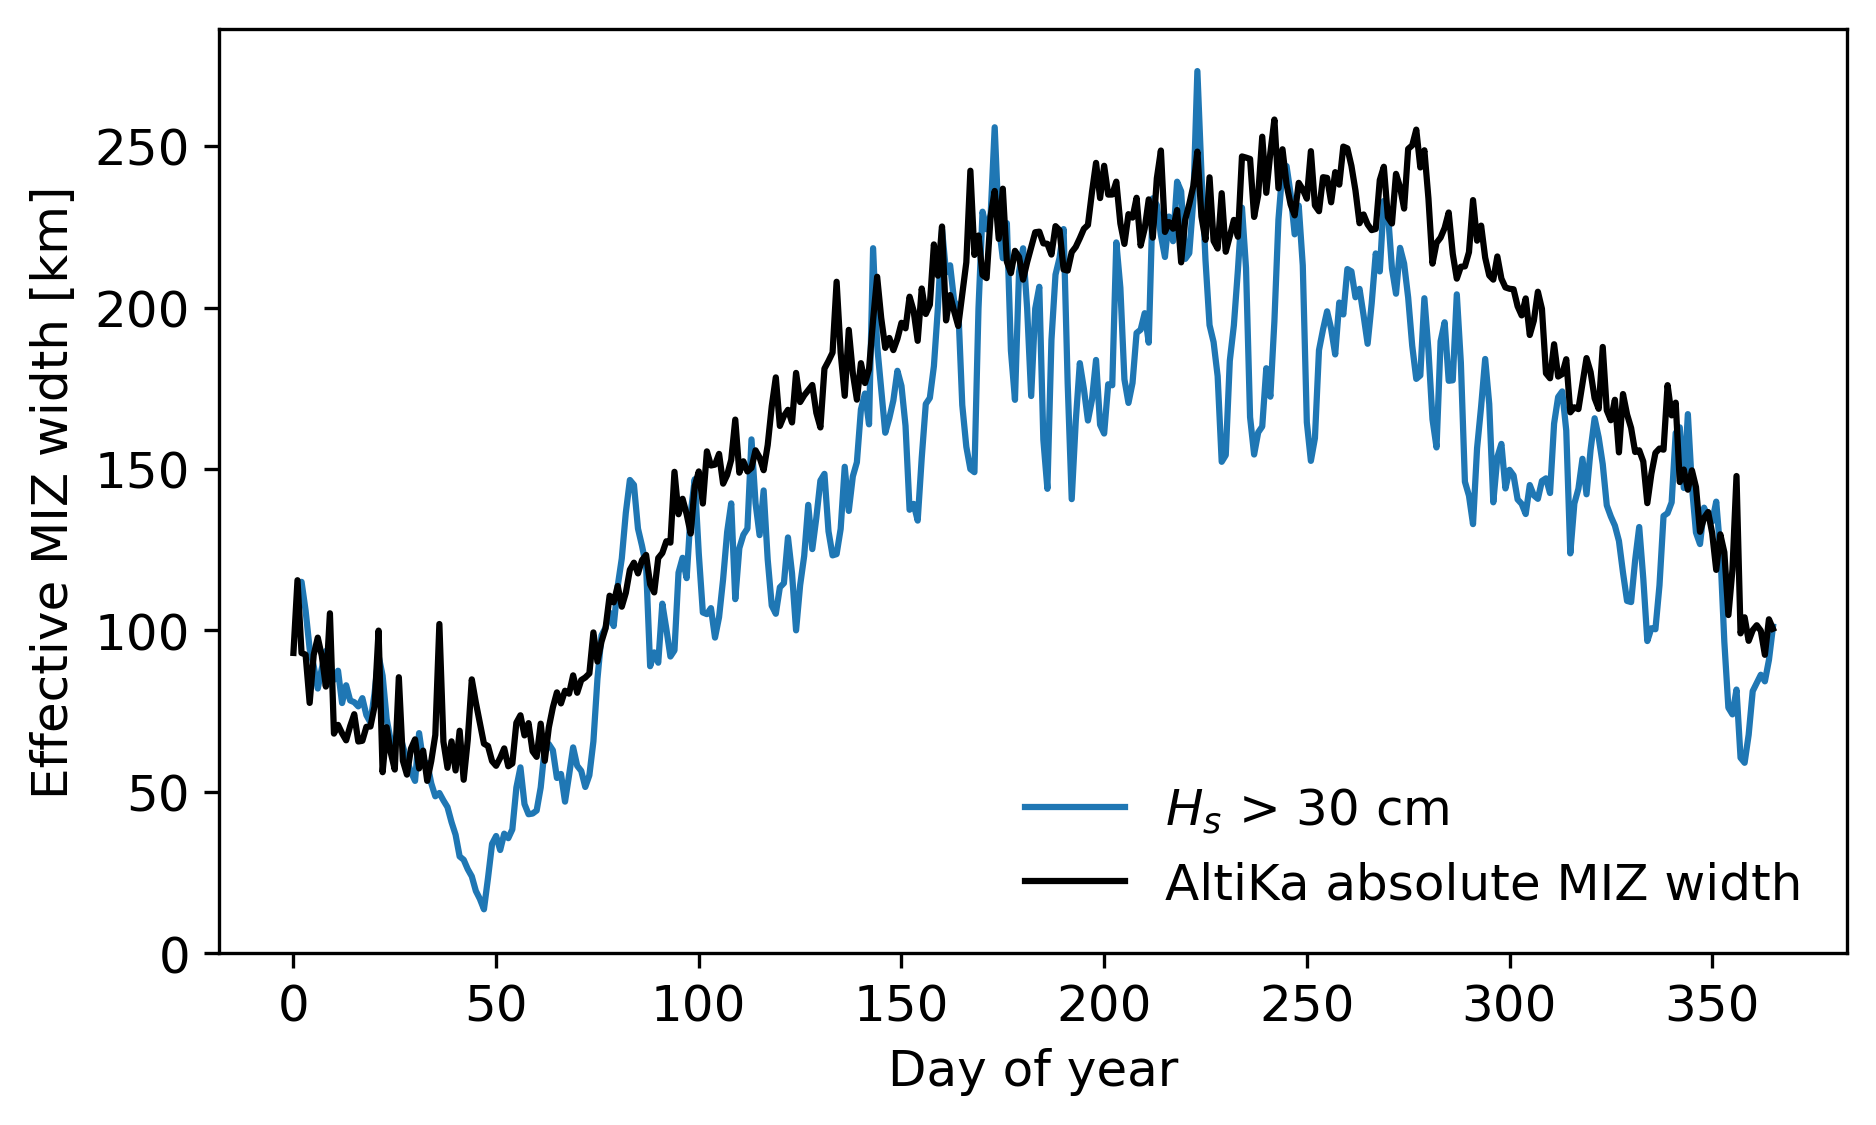

In [183]:
# region = 'ANTARCTICA'
fig, axes = plt.subplots(ncols=1, figsize=(7,4), sharex=True, sharey=True)
ax = axes
x = ds_doy.dayofyear
# ax.plot(x, antarctic_miz_width_wave_d_eff_1cm, label='$H_s$ > 1 cm')
# ax.plot(x, antarctic_miz_width_wave_d_eff_5cm, label='$H_s$ > 5 cm')
ax.plot(x, antarctic_miz_width_wave_d_eff, label='$H_s$ > 30 cm')

# ax.plot(x, antarctic_miz_width_fsdrad_d_eff, label=f'Floe radii < {floe_size_threshold} m')
# axes[0].plot(x, antarctic_miz_width_aice_d, label='Ice concentration', color='lightblue')

ax.plot(range(366), df_doy['mizWidthAlongTrackFromMyEdge'], color='k', label="AltiKa absolute MIZ width")

ax.legend(frameon=False, ncols=1, fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlabel("Day of year")
ax.set_ylabel("Effective MIZ width [km]")

In [85]:
# df_all['doy'] = pd.to_datetime(df_all['date']).dt.dayofyear
# df_doy = df_all.groupby('doy').mean(numeric_only=True)

In [ ]:
# plt.figure(figsize=(8, 5))
# plt.scatter(
#     df_all['lonAtMyEdge'],
#     df_all['doy'],
#     c=df_all['mizWidthAlongTrackFromMyEdge'],
#     s=20
# )
# plt.colorbar(label='MIZ Width (km)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('MIZ Width Along Track')
# plt.show()

In [ ]:
# X, Y = np.meshgrid(df_all['lonAtMyEdge'], df_all['doy'])
# Z = df_all['mizWidthAlongTrackFromMyEdge']

# plt.pcolormesh(X, Y, Z, shading='auto')
# plt.colorbar()

In [42]:
client.close()

2025-12-03 16:15:33,452 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,453 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,454 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,459 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,459 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,460 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-12-03 16:15:33,468 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
